In [ ]:
## RAUL

#**PROBLEMA DE NEGOCIO**


---




##Imagina tener acceso a los datos de una plataforma de streaming y usar esos datos para mejorar la experiencia del usuario. Como científicos de datos, analizarán estos datos con Python y construirán un recomendador de películas personalizado que ofrecerá sugerencias precisas y relevantes, revolucionando la forma en que los usuarios descubren nuevos contenidos.

### **Objetivos**

1. Recomendador no personalizado

2. Recomendador Content-based

3. Recomendador Collaborative filtering

#**1. Configuración del Ambiente**


---




In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies, df_ratings, df_final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  2313k      0 --:--:-- --:--:-- --:--:-- 2313k


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [65]:
df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [66]:
df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,964982703
1,1,3,4.00,964981247
2,1,6,4.00,964982224
3,1,47,5.00,964983815
4,1,50,5.00,964982931


##**2.2 Tratamiento de Datos**

In [28]:
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
-------------


In [68]:
# Creamos la funcion de preprocesamiento
def preprocesamiento():
  global df_movies, df_ratings

  #eliminamos los registros con valores nulos en ambos dataframes
  df_movies = df_movies.dropna()
  df_ratings = df_ratings.dropna()

  #df_movies: Eliminamos duplicados considerando la columna movieId como llave:
  df_movies = df_movies.drop_duplicates(subset='movieId', keep='first')

  #---- df_ratings: Eliminamos duplicados considerando las columnas movieId y userId como llaves
  df_ratings = df_ratings.drop_duplicates(subset=['movieId', 'userId'], keep='first')

  #---- creamos la columna content a partir de la columna genres, reemplazando | por espacios
  df_movies['content'] = df_movies['genres'].str.replace('|', ' ')

  #---- En df_movies creamos la columna genre_set a partir de la columna genres, esta nueva columna es de tipo set y contiene todos los géneros separados por coma
  df_movies['genre_set'] = df_movies['genres'].str.split('|')
  df_movies['genre_set'] = df_movies['genre_set'].apply(set)

  #---- Convertimos la columna  timestamp de  df_ratings a formato fecha hora
  df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
  print(df_ratings.head())
  # Verificar el tipo de dato
  #df_ratings['timestamp']=df_ratings['timestamp'].astype('datetime64[ns]')
  print(df_ratings.head())

In [72]:
preprocesamiento()
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

   userId  movieId  rating           timestamp
0       1        1    4.00 2000-07-30 18:45:03
1       1        3    4.00 2000-07-30 18:20:47
2       1        6    4.00 2000-07-30 18:37:04
3       1       47    5.00 2000-07-30 19:03:35
4       1       50    5.00 2000-07-30 18:48:51
   userId  movieId  rating           timestamp
0       1        1    4.00 2000-07-30 18:45:03
1       1        3    4.00 2000-07-30 18:20:47
2       1        6    4.00 2000-07-30 18:37:04
3       1       47    5.00 2000-07-30 19:03:35
4       1       50    5.00 2000-07-30 18:48:51
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   int64 
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB
None


In [31]:
df_movies.head()

,movieId,title,genres,content,genre_set
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Adventure, Animation, Children, Comedy, Fantasy}"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"{Adventure, Children, Fantasy}"
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"{Comedy, Romance}"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"{Comedy, Drama, Romance}"
4,5,Father of the Bride Part II (1995),Comedy,Comedy,{Comedy}


In [73]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,2000-07-30 18:45:03
1,1,3,4.00,2000-07-30 18:20:47
2,1,6,4.00,2000-07-30 18:37:04
3,1,47,5.00,2000-07-30 19:03:35
4,1,50,5.00,2000-07-30 18:48:51


##**2.3 Análisis Exploratorio (EDA)**

In [9]:
df_movies.describe()

,movieId
count,9742.00
mean,42200.35
std,52160.49
min,1.00
25%,3248.25
50%,7300.00
75%,76232.00
max,193609.00


In [24]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836
mean,326.13,19435.30,3.50,1970-01-01 00:00:01.205946087
min,1.00,1.00,0.50,1970-01-01 00:00:00.828124615
25%,177.00,1199.00,3.00,1970-01-01 00:00:01.019123866
50%,325.00,2991.00,3.50,1970-01-01 00:00:01.186086662
75%,477.00,8122.00,4.00,1970-01-01 00:00:01.435994144
max,610.00,193609.00,5.00,1970-01-01 00:00:01.537799250
std,182.62,35530.99,1.04,NaN


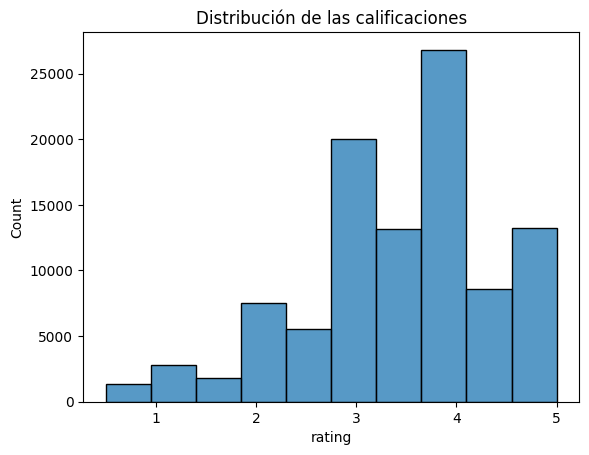

In [11]:
# Histograma de la columna 'rating' en df_ratings
sns.histplot(df_ratings['rating'], bins=10)
plt.title('Distribución de las calificaciones')
plt.show()

In [12]:
movies_expanded = df_movies.assign(genre=df_movies['genres'].str.split('|')).explode('genre')
movies_expanded.head()

,movieId,title,genres,content,genre_set,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Adventure, Animation, Children, Comedy, Fantasy}",Adventure
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Adventure, Animation, Children, Comedy, Fantasy}",Animation
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Adventure, Animation, Children, Comedy, Fantasy}",Children
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Adventure, Animation, Children, Comedy, Fantasy}",Comedy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Adventure, Animation, Children, Comedy, Fantasy}",Fantasy


<ipython-input-22-27fe6529606a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='percentage', y='genre', data=generos, palette='viridis')


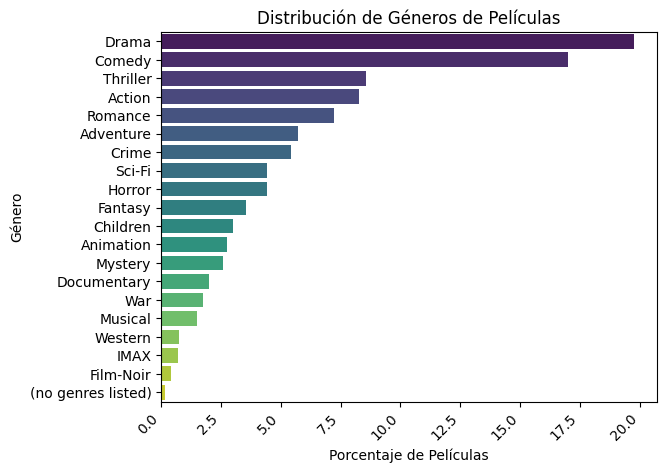

In [22]:
generos=movies_expanded.groupby('genre').size().reset_index(name='movies_count')
generos['percentage'] = (generos['movies_count'] / generos['movies_count'].sum()) * 100
generos=generos.sort_values(by='movies_count', ascending=False)


sns.barplot(x='percentage', y='genre', data=generos, palette='viridis')

# Personalizar el gráfico
plt.title('Distribución de Géneros de Películas')
plt.xlabel('Porcentaje de Películas')
plt.ylabel('Género')
plt.xticks(rotation=45, ha='right')
plt.show()

In [83]:
df_ratings['timestamp'].dt.year.value_counts()

,count
timestamp,
2000,10061
2017,8198
2007,7114
2016,6703
2015,6616
2018,6418
1996,6040
2005,5813
2012,4656


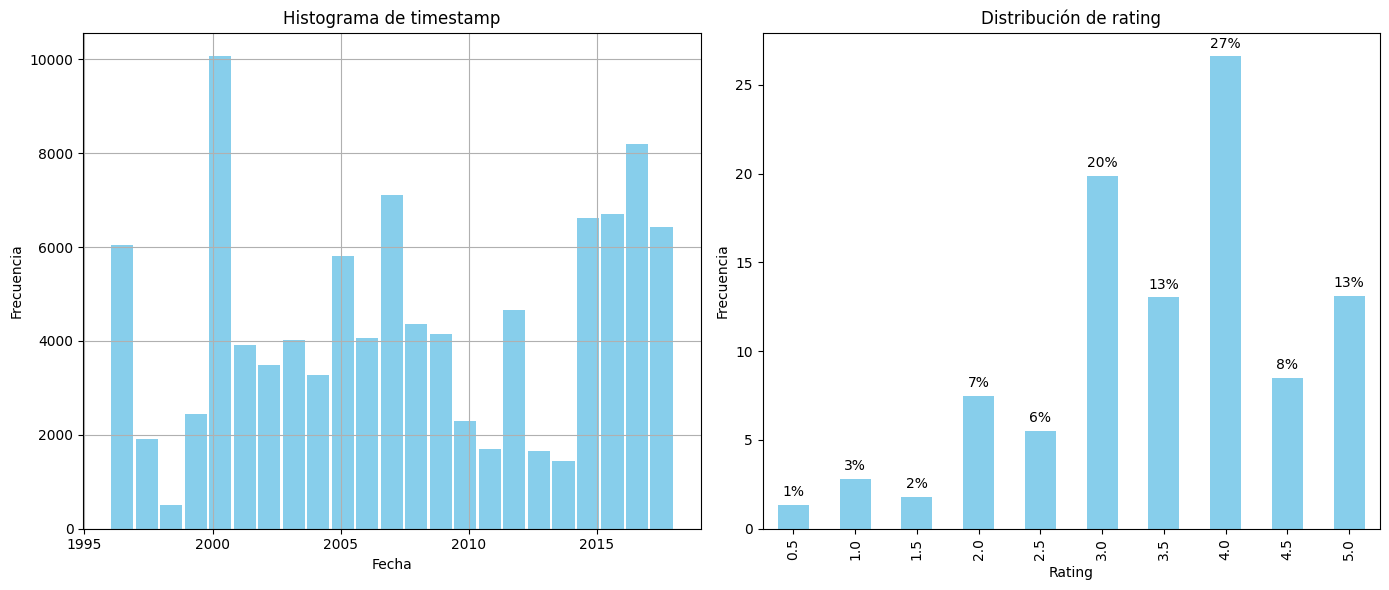

In [88]:
plt.figure(figsize=(14, 6)) #Crea una nueva figura en pulgadas, donde 14 es el ancho y 6 es la altura

plt.subplot(1, 2, 1) #Divide la figura en una cuadrícula de 1 fila y 2 columnas y selecciona el primer gráfico
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
df_ratings['timestamp'].dt.year.hist(bins=23, color='skyblue', rwidth=0.9) #El método dt.year obtiene el año de la fecha
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.title('Histograma de timestamp')

# Histograma de la rating
plt.subplot(1, 2, 2) #Selecciona el segundo gráfico de la cuadrícula (ubicado en la segunda columna).
ratings_counts = df_ratings['rating'].value_counts(normalize=True) * 100 #Calcula la frecuencia de cada valor en la columna rating
ratings_counts.sort_index().plot(kind='bar', color='skyblue')

for i, v in enumerate(ratings_counts.sort_index()): #enumerate() devuelve tanto el índice como el valor en cada iteración.
    plt.text(i, v + 0.5, f"{v:.0f}%", ha='center') # coloca el porcentaje a cada barra

plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.title('Distribución de rating')

plt.tight_layout()
plt.show()

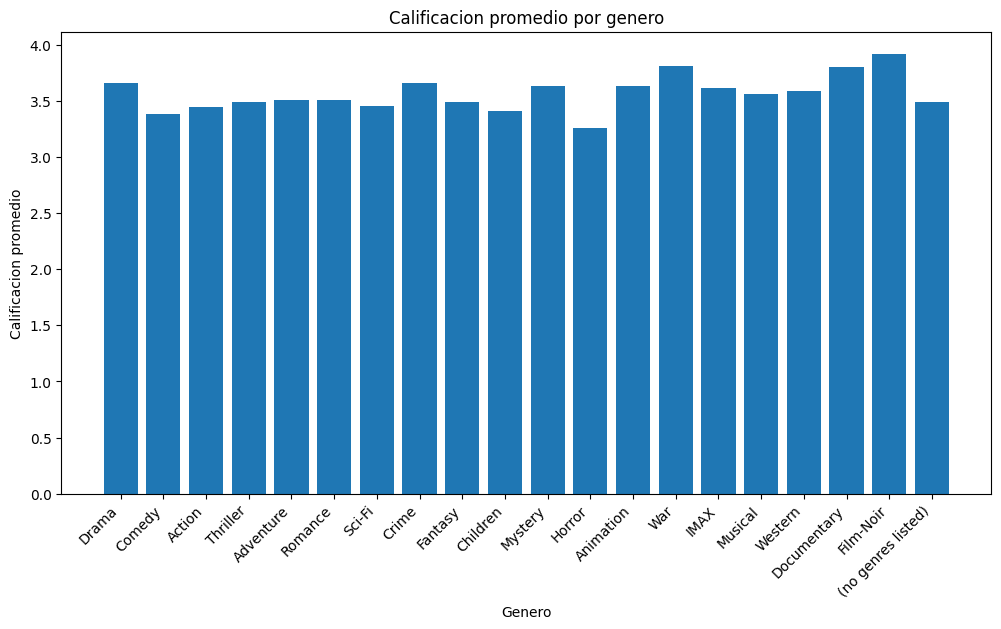

In [89]:
# Separar los múltiples valores en la columna 'genres'
movies_expanded = df_movies.assign(genre=df_movies['genres'].str.split('|')).explode('genre')

# Agrupar por 'genre' y calcular el promedio de 'rating' y el total de películas
genre_stats = movies_expanded.merge(df_ratings, on='movieId', how='inner') \
                            .groupby('genre') \
                            .agg(
                                avg_rating=('rating', 'mean'),
                                num_movies=('movieId', 'count')
                            ).reset_index()

genre_stats.sort_values(by='num_movies', ascending=False, inplace=True)
genre_stats.reset_index(drop=True, inplace=True)

# Visualización
plt.figure(figsize=(12, 6))
plt.bar(genre_stats['genre'], genre_stats['avg_rating'])
plt.xlabel('Genero')
plt.ylabel('Calificacion promedio')
plt.title('Calificacion promedio por genero')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
genre_stats['percentage'] = (genre_stats['num_movies'] / genre_stats['num_movies'].sum()) * 100
genre_stats

,genre,avg_rating,num_movies,percentage
0,Drama,3.66,41928,15.28
1,Comedy,3.38,39053,14.23
2,Action,3.45,30635,11.16
3,Thriller,3.49,26452,9.64
4,Adventure,3.51,24161,8.80
5,Romance,3.51,18124,6.60
6,Sci-Fi,3.46,17243,6.28
7,Crime,3.66,16681,6.08
8,Fantasy,3.49,11834,4.31
9,Children,3.41,9208,3.35


<ipython-input-108-317d23ee90fe>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='percentage', y='genre', data=genre_stats, palette='viridis')


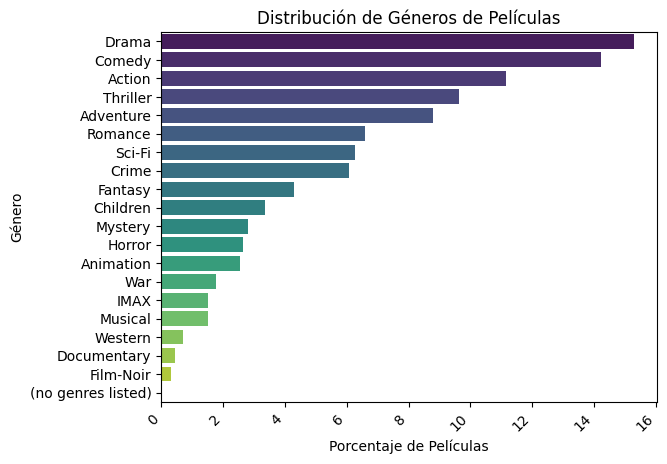

In [ ]:
# Suponiendo que tienes un DataFrame llamado 'genre_stats' con las columnas 'genre' y 'percentage'
sns.barplot(x='percentage', y='genre', data=genre_stats, palette='viridis')

# Personalizar el gráfico
plt.title('Distribución de Géneros de Películas')
plt.xlabel('Porcentaje de Películas')
plt.ylabel('Género')
plt.xticks(rotation=45, ha='right')
plt.show()

In [90]:
df_final = pd.merge(df_ratings, df_movies, on='movieId')

In [91]:
df_final.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836
mean,326.13,19435.30,3.50,2008-03-19 17:01:27.368469504
min,1.00,1.00,0.50,1996-03-29 18:36:55
25%,177.00,1199.00,3.00,2002-04-18 09:57:46
50%,325.00,2991.00,3.50,2007-08-02 20:31:02
75%,477.00,8122.00,4.00,2015-07-04 07:15:44.500000
max,610.00,193609.00,5.00,2018-09-24 14:27:30
std,182.62,35530.99,1.04,NaN


In [92]:
df_final.head()

,userId,movieId,rating,timestamp,title,genres,content,genre_set
0,1,1,4.00,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Adventure, Animation, Children, Comedy, Fantasy}"
1,5,1,4.00,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Adventure, Animation, Children, Comedy, Fantasy}"
2,7,1,4.50,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Adventure, Animation, Children, Comedy, Fantasy}"
3,15,1,2.50,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Adventure, Animation, Children, Comedy, Fantasy}"
4,17,1,4.50,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Adventure, Animation, Children, Comedy, Fantasy}"


#**3. Estrategias de Recomendación**


---




##**3.1 Recomendación no personalizada**

In [104]:
#@title
def recomendacion_populares():
  # Agrupar por movieId para calcular el promedio de las valoraciones (mean_rating) y contar el número de votos (vote_count)
  movie_stats = df_final.groupby('movieId').agg({
      'rating': ['mean', 'count']
  }).reset_index()
  #print(movie_stats.head())
  # Cambiar el nombre de las columnas
  movie_stats.columns = ['movieId', 'mean_rating', 'vote_count']

  # Unimos con la tabla de películas para obtener el título
  movie_stats = pd.merge(movie_stats, df_movies[['movieId', 'title']], on='movieId')

  # Calcular la puntuación ponderada (weighted_score)
  C = movie_stats['mean_rating'].mean()
  m = movie_stats['vote_count'].quantile(0.90)  # Umbral de votos para considerar la popularidad (puede ajustarse)

  movie_stats['weighted_score'] = movie_stats.apply(
      lambda x: (x['vote_count']/(x['vote_count']+m) * x['mean_rating']) + (m/(m+x['vote_count']) * C),
      axis=1
  )

  # Ordenar por weighted_score y seleccionar las 10 primeras películas
  top_10_movies = movie_stats.sort_values('weighted_score', ascending=False).head(10)
  return top_10_movies


In [105]:
recomendacion_populares()


,movieId,mean_rating,vote_count,title,weighted_score
277,318,4.43,317,"Shawshank Redemption, The (1994)",4.34
659,858,4.29,192,"Godfather, The (1972)",4.16
2224,2959,4.27,218,Fight Club (1999),4.16
224,260,4.23,251,Star Wars: Episode IV - A New Hope (1977),4.14
46,50,4.24,204,"Usual Suspects, The (1995)",4.12
257,296,4.20,307,Pulp Fiction (1994),4.12
461,527,4.22,220,Schindler's List (1993),4.12
1938,2571,4.19,278,"Matrix, The (1999)",4.11
897,1196,4.22,211,Star Wars: Episode V - The Empire Strikes Back...,4.11
314,356,4.16,329,Forrest Gump (1994),4.10


##**3.2 Recomendación Content-Based**

###**3.2.1 Similitud de Jaccard**

In [ ]:
#@title
def recomendacion_jaccard(movie_id, df_movies, n_recommendations=10):
    #Tu código aquí
    return recommendations

In [ ]:
recomendaciones = recomendacion_jaccard(1, df_movies, n_recommendations=10)
recomendaciones

,movieId,title,genres,similarity
2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,1.00
6194,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,1.00
6948,65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,1.00
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.00
3568,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1.00
8219,103755,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy,1.00
9430,166461,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy,1.00
1706,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,1.00
3000,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.00
7760,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,1.00


###**3.2.2 Similitud de Coseno con TF-IDF**

In [ ]:
#@title
def recomendacion_tf_idf(movie_id, df_movies, cosine_sim, n_recommendations=10):
    #Tu código aquí
    return df_movies

In [ ]:
recomendaciones = recomendacion_tf_idf(58559, df_movies, cosine_sim, n_recommendations=10)
recomendaciones

,movieId,title,genres,distance
8387,109850,Need for Speed (2014),Action|Crime|Drama|IMAX,1.00
5917,33794,Batman Begins (2005),Action|Crime|IMAX,0.96
7599,86644,"Fast Five (Fast and the Furious 5, The) (2011)",Action|Crime|Drama|Thriller|IMAX,0.93
6852,62081,Eagle Eye (2008),Action|Crime|Thriller|IMAX,0.89
8103,100498,"Good Day to Die Hard, A (2013)",Action|Crime|Thriller|IMAX,0.89
8166,102716,"Fast & Furious 6 (Fast and the Furious 6, The)...",Action|Crime|Thriller|IMAX,0.89
8149,102088,"Grandmaster, The (Yi dai zong shi) (2013)",Action|Drama|IMAX,0.89
7768,91529,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX,0.87
8233,104129,Man of Tai Chi (2013),Action|IMAX,0.85
8201,103339,White House Down (2013),Action|Drama|Thriller|IMAX,0.82


##**3.3 Recomendación Collaborative Filtering**

In [ ]:
#@title
def recomendacion_knn(usuario_id_o_ratings, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model, n_recommendations=10):
  #Tu código aquí
  return recommendations


In [ ]:
#usuario = 15
usuario = pd.Series({
    356: 4,
    58559: 5
})

recomendaciones = recomendacion_knn(usuario, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model)
recomendaciones

,movieId,title,genres,mean_rating
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.43
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,0.19
123,150,Apollo 13 (1995),Adventure|Drama|IMAX,0.19
659,858,"Godfather, The (1972)",Crime|Drama,0.18
287,329,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi,0.17
322,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,0.17
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0.16
6743,59315,Iron Man (2008),Action|Adventure|Sci-Fi,0.15
902,1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi,0.14
6885,63082,Slumdog Millionaire (2008),Crime|Drama|Romance,0.13
